In [1]:
import math
import numpy as np
import codecs, json 
import cv2
import matplotlib.pyplot as plt
from sklearn import mixture
from scipy import linalg as la
from scipy import stats as st
from scipy.interpolate import griddata

In [2]:
# c_error = np.array([[-0.91, -0.16, -0.23,  0.  , -0.09,  0.1 ,  0.31,  0.08],
#        [-0.71, -0.19, -0.24, -0.05, -0.18, -0.02,  0.05, -0.09],
#        [-0.66, -0.13, -0.36, -0.1 , -0.1 , -0.12, -0.03,  0.2 ],
#        [-0.44, -0.28, -0.28, -0.11, -0.21, -0.13, -0.03, -0.21],
#        [-0.3 , -0.09, -0.38, -0.27, -0.02, -0.29, -0.16, -0.11],
#        [ 0.1 ,  0.28,  0.15,  0.2 ,  0.09,  0.17, -0.22,  0.21],
#        [-0.28,  0.26,  0.42,  0.47,  0.62,  0.71,  0.66,  0.48],
#        [-0.37,  0.06,  0.45,  0.6 ,  0.58,  0.39,  0.56,  0.36]])

c_error = np.array([[ 0.53,  0.17,  0.27,  0.27,  0.33,  0.33,  0.31,  0.28],
       [ 0.19, -0.05,  0.02,  0.05,  0.11,  0.06,  0.03, -0.01],
       [ 0.21, -0.  ,  0.13,  0.08,  0.14,  0.14,  0.04, -0.05],
       [ 0.27, -0.05,  0.09,  0.04,  0.15,  0.19,  0.05, -0.05],
       [ 0.22, -0.24, -0.14, -0.  ,  0.08,  0.16,  0.03, -0.05],
       [ 0.01, -0.4 , -0.28, -0.1 , -0.05,  0.07,  0.03, -0.05],
       [-0.23, -0.42, -0.3 , -0.22, -0.13,  0.01,  0.03, -0.08],
       [-0.21, -0.46, -0.28, -0.24, -0.17,  0.01, -0.08, -0.13]])

c_maxnoise = np.array([[0.42, 0.18, 0.24, 0.26, 0.36, 0.42, 0.45, 0.44],
       [0.22, 0.21, 0.26, 0.31, 0.2 , 0.28, 0.22, 0.36],
       [0.18, 0.14, 0.12, 0.37, 0.12, 0.14, 0.29, 0.32],
       [0.2 , 0.3 , 0.29, 0.13, 0.23, 0.15, 0.3 , 0.23],
       [0.31, 0.1 , 0.14, 0.28, 0.29, 0.31, 0.18, 0.38],
       [0.42, 0.23, 0.37, 0.31, 0.18, 0.34, 0.24, 0.3 ],
       [0.29, 0.26, 0.34, 0.3 , 0.15, 0.3 , 0.35, 0.28],
       [0.39, 0.46, 0.32, 0.42, 0.43, 0.37, 0.46, 0.4 ]])

def read_tempdata(rn, path):
    arr = np.zeros([rn,8,8])
    with open(path) as f:
        for k in range(rn):
            for i in range(8):
                line = f.readline()
                t = [float(x) for x in line.split()]
                arr[k,i] = t
            line = f.readline()
#     arr = arr - c_error
    arr = np.amax(arr, axis = 0) - c_maxnoise
    return arr

def read_gtempdata(rn,gpath,num):
    garr = np.zeros([num,8,8])
    for n in range(num):
        path = gpath + str(n+1) +'.txt'
        garr[n] = read_tempdata(rn, path)
    return garr

In [3]:
points = [(math.floor(ix / 8), (ix % 8)) for ix in range(0, 64)]
grid_x, grid_y = np.mgrid[0:7:64j, 0:7:64j]

def show_temp(arr, mintemp = 26, maxtemp = 32):
    plt.figure(figsize=(6,5))
    bicubic = griddata(points, arr.reshape(-1), (grid_x, grid_y), method='cubic')
    pcm = plt.pcolormesh(np.flip(bicubic,0), cmap='jet', vmin = mintemp, vmax = maxtemp)
    plt.colorbar(pcm, fraction=0.175,pad=0.02)
    plt.axis('off')
    plt.show()
    
    return np.amax(bicubic)


def show_gtemp(garr,ln,weight = None, mintemp = 26, maxtemp = 32):
    fig, axs = plt.subplots(ln, ln, figsize=(15, 15))
    amax = np.zeros((ln,ln))
    for n in range(ln**2):
        col = int(n/ln)
        row = int(n%ln)
        bicubic = griddata(points, garr[n].reshape(-1), (grid_x, grid_y), method='cubic')
        if np.any(weight) != None:
            wbicubic = griddata(points, weight[n].reshape(-1)*80, (grid_x, grid_y), method='cubic')/80
            wbicubic[wbicubic < 0] = 0
            wbicubic[wbicubic > 1] = 1
            bicubic = bicubic*(1-wbicubic) + np.amin(garr)*wbicubic
        ax = axs[col,row]
        pcm = ax.pcolormesh(np.flip(bicubic,0), cmap='jet', vmin = mintemp, vmax = maxtemp)
        ax.set_axis_off()
        amax[col,row] = np.amax(bicubic)
    
    fig.colorbar(pcm, ax= axs[:], fraction=0.0175,pad=0.02)

    plt.show()
    print(amax.round(2))

In [1]:
lbicubic = []
def get_weight(garr,arrbg):
    diff = garr.reshape(-1,64)-arrbg.reshape(-1)
    
    weight = np.ones(diff.shape)
    for i in range(diff.shape[0]):
        n = 0
        n_skew = 10000
        bicubic = np.around(griddata(points, diff[i], (grid_x, grid_y), method='cubic').reshape(-1) * 4)/4.
        lbicubic.append(bicubic)
        sort_diff = np.unique(bicubic)
        mode =  0
        start = 0
        for j in range(int(sort_diff.shape[0]/2)):
            num = bicubic[bicubic == sort_diff[j]].shape[0]
            if (num > mode):
                mode = num
                start = j
        for j in range(max(2,start),int(sort_diff.shape[0]/2)):
            t_skew = abs(st.skew(bicubic[bicubic < sort_diff[j]] ))
            if t_skew < n_skew:
                n_skew = t_skew
                n = sort_diff[j]
        weight[i,diff[i] >= n] = 0 
    
    return weight.reshape(-1,8,8)

In [5]:
def thermal_interpolate(garr,oy,ox,ny,nx):
    interpol = np.zeros((ny,nx,8,8))
    garr2 = garr.reshape((oy,ox,8,8))
    for i in range(ny):
        for j in range(nx):
            y2 = max(0,math.ceil(i*(oy-1)/(ny-1)))
            y1 = y2-1
            x2 = max(0,math.ceil(j*(ox-1)/(nx-1)))
            x1 = x2-1
            ly = i*(oy-1)/(ny-1) - y1
            lx = j*(ox-1)/(nx-1) - x1
            inter1 = garr2[y1,x1]*(1-ly)+garr2[y2,x1]*ly
            inter2 = garr2[y1,x2]*(1-ly)+garr2[y2,x2]*ly
            interpol[i,j] = inter1*(1-lx)+inter2*lx
    return interpol.reshape(-1,8,8)


In [21]:
# def output_interpolate(temp_path, ln2):
#     bgpath = 'train/' + temp_path + '/output-empty/1.txt'
#     interpol = np.zeros((4,ln2**2,8,8))
#     ln = 6
#     for i in range(4):
#         datapath = 'train/' + temp_path + '/output-' + str(i+1)+ '/'

#         garr = read_gtempdata(100,datapath,ln**2)
#         arrbg = read_tempdata(100,bgpath)

#         weight = get_weight(garr,arrbg)

#         bg_mean = np.sum(garr*(weight),axis = (1,2))/np.sum(weight,axis = (1,2))
#         bg_max = np.max(bg_mean)

#         garr2 = (garr.transpose(1,2,0) + bg_max-bg_mean).transpose(2,0,1)
#         interpol[i] = thermal_interpolate(garr2,ln,ln,ln2,ln2)
#         ln -= 1
#     return interpol

def output_interpolate(temp_path, ln2):
    bgpath = 'train/' + temp_path + '/output-empty/1.txt'
    interpol = np.zeros((4,ln2**2,8,8))
    ln = 6
    bg_max = 0
    for i in range(4):
        datapath = 'train/' + temp_path + '/output-' + str(i+1)+ '/'

        garr = read_gtempdata(100,datapath,ln**2)
        arrbg = read_tempdata(100,bgpath)

        weight = get_weight(garr,arrbg)

        bg_mean = np.sum(garr*(weight),axis = (1,2))/np.sum(weight,axis = (1,2))
#         bg_max += np.mean(bg_mean)
        bg_max = max(bg_max,np.max(bg_mean))

        garr2 = (garr.transpose(1,2,0) -bg_mean).transpose(2,0,1)
        interpol[i] = thermal_interpolate(garr2,ln,ln,ln2,ln2)
        ln -= 1
#     bg_max /= 4
    return interpol+bg_max

def batch_interpolate(interpol):
    super_interpol = thermal_interpolate(interpol,4,64,8,64).reshape(8,8,8,8,8).transpose(1,0,2,3,4).reshape(-1,64,8,8)
    amax = np.zeros((8,8,8))
    ln = 8
    for layer in range(8):
        for n in range(ln**2):
            col = int(n/ln)
            row = int(n%ln)
            bicubic = griddata(points, super_interpol[layer,n].reshape(-1), (grid_x, grid_y), method='cubic')
            amax[layer,col,row] = np.amax(bicubic)
    return super_interpol, amax

def full_interpolate(ln):
    interpol = np.zeros((3,4,ln**2,8,8))
    super_interpol = np.zeros((3,ln**3,8,8))
    temp_path = np.array(['warm','semicold','cold'])
    for i in range(3):
        interpol[i] = output_interpolate(temp_path[i],ln)
        super_interpol[i] = thermal_interpolate(interpol[i],4,ln**2,ln,ln**2)
    full_interpol = thermal_interpolate(super_interpol,3,ln**3,ln,ln**3).reshape(ln,ln,ln**2,8,8)
    
    amax = np.zeros((ln,ln,ln,ln))
    for amb in range(ln):
        for layer in range(ln):
            for n in range(ln**2):
                col = int(n/ln)
                row = int(n%ln)
                bicubic = griddata(points, full_interpol[amb,layer,n].reshape(-1), (grid_x, grid_y), method='cubic')
                amax[amb,layer,col,row] = np.amax(bicubic)
                
    return full_interpol, amax

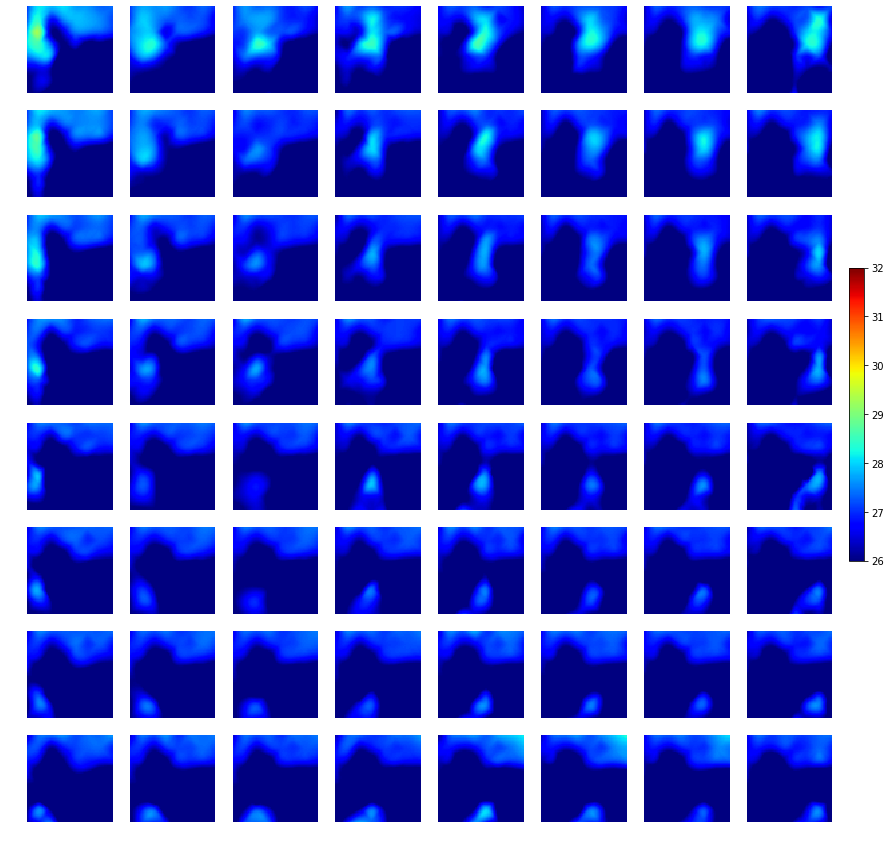

[[29.26 28.37 28.53 28.5  28.65 28.39 28.38 28.41]
 [28.79 28.04 27.6  28.08 28.33 28.01 28.24 28.22]
 [28.43 27.91 27.6  27.79 27.78 27.61 27.8  28.04]
 [28.45 27.73 27.73 27.56 27.79 27.4  27.53 27.79]
 [27.93 27.53 27.5  27.96 27.84 27.47 27.62 27.82]
 [27.76 27.44 27.43 27.47 27.5  27.43 27.48 27.5 ]
 [27.51 27.46 27.47 27.47 27.68 27.49 27.34 27.61]
 [27.61 27.63 27.59 27.63 28.14 28.28 28.04 27.59]]


In [22]:
temp_path = 'semicold'

interpol = output_interpolate(temp_path,8)

show_gtemp(interpol[0],8)

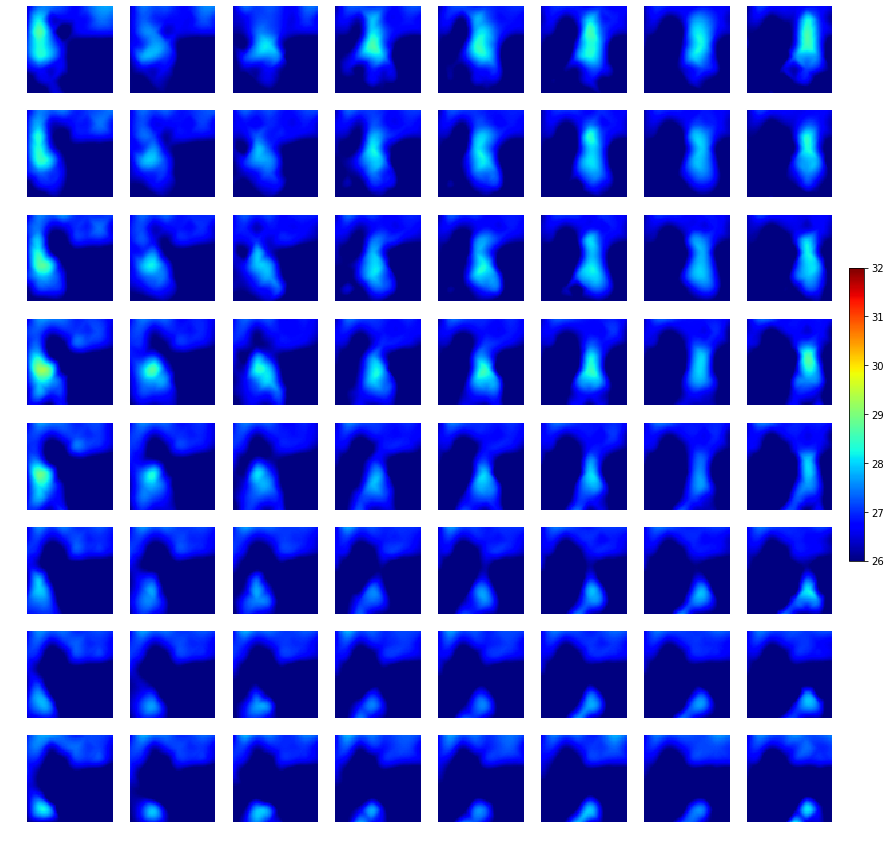

[[28.72 27.85 28.15 28.65 28.52 28.59 28.28 28.65]
 [28.48 27.96 27.9  28.26 28.25 28.4  28.04 28.42]
 [28.76 28.2  27.98 28.15 28.37 28.21 27.99 28.22]
 [29.3  28.7  28.41 28.28 28.56 28.51 28.06 28.71]
 [28.93 28.32 28.09 27.9  28.07 28.1  27.7  28.05]
 [28.02 27.73 27.75 27.66 27.72 27.89 27.9  28.21]
 [27.84 27.7  27.75 27.74 27.64 27.78 27.69 27.93]
 [28.24 27.94 27.97 27.77 27.64 27.96 27.6  28.1 ]]


In [23]:
show_gtemp(interpol[1],8)

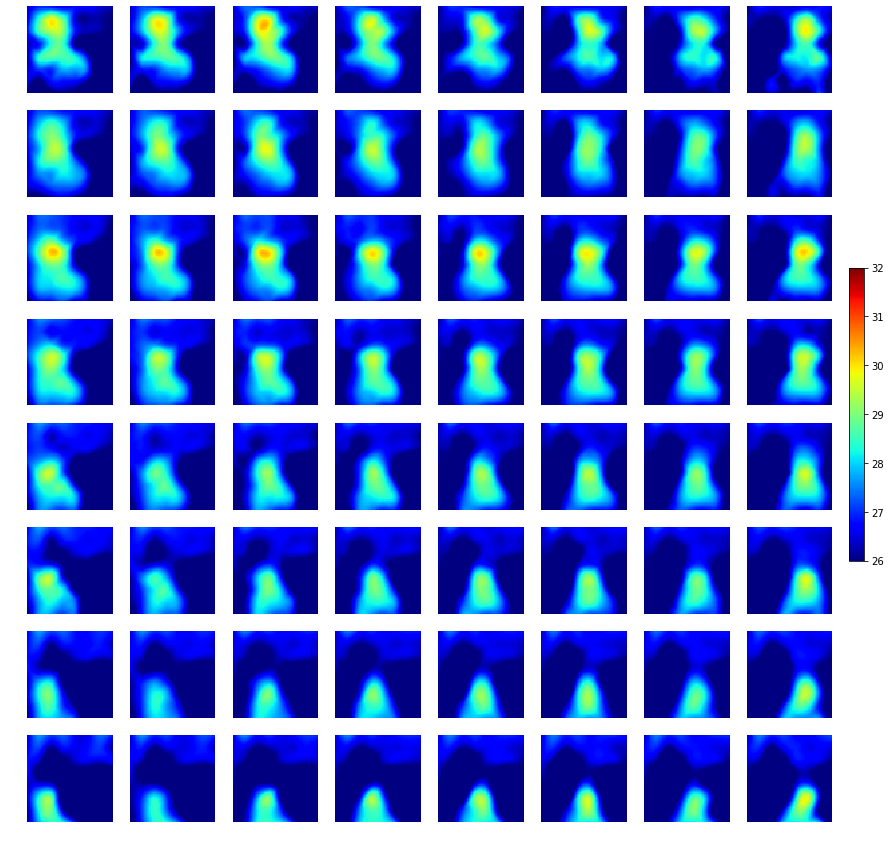

[[30.06 30.05 30.39 29.81 29.65 29.77 29.56 29.95]
 [29.49 29.61 29.82 29.57 29.39 29.18 29.09 29.5 ]
 [30.32 30.28 30.37 30.12 30.14 29.98 29.79 30.19]
 [29.61 29.54 29.68 29.56 29.61 29.52 29.28 29.62]
 [29.58 28.91 29.22 29.26 29.35 29.47 29.18 29.69]
 [29.54 28.7  29.07 29.08 29.21 29.33 29.04 29.77]
 [29.04 28.44 29.06 29.14 29.23 29.33 28.92 29.55]
 [29.35 28.52 29.19 29.37 29.46 29.7  29.1  29.93]]


In [24]:
show_gtemp(interpol[2],8)

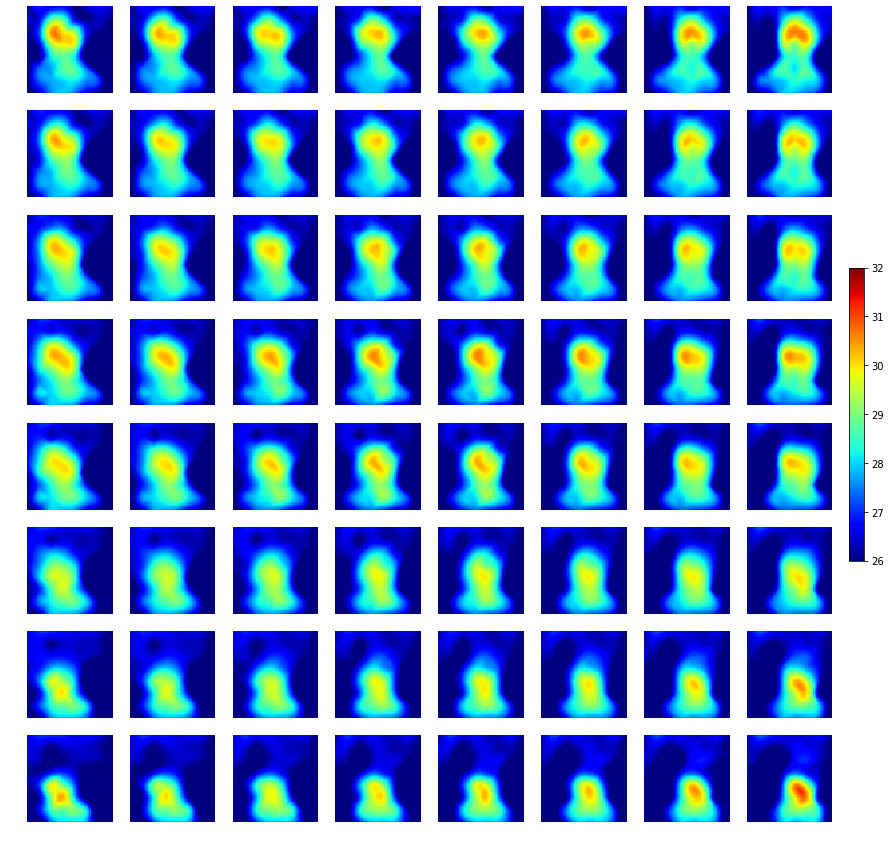

[[30.75 30.4  30.22 30.35 30.45 30.5  30.56 30.68]
 [30.48 30.2  30.09 30.22 30.31 30.3  30.3  30.31]
 [30.34 30.16 30.18 30.33 30.4  30.36 30.33 30.3 ]
 [30.43 30.35 30.47 30.62 30.67 30.58 30.56 30.57]
 [30.07 30.1  30.25 30.43 30.46 30.37 30.3  30.3 ]
 [29.7  29.59 29.7  29.9  29.97 29.93 29.95 30.07]
 [30.03 29.77 29.67 29.89 30.   30.04 30.23 30.64]
 [30.42 30.08 29.88 30.12 30.3  30.3  30.58 31.22]]


In [25]:
show_gtemp(interpol[3],8)

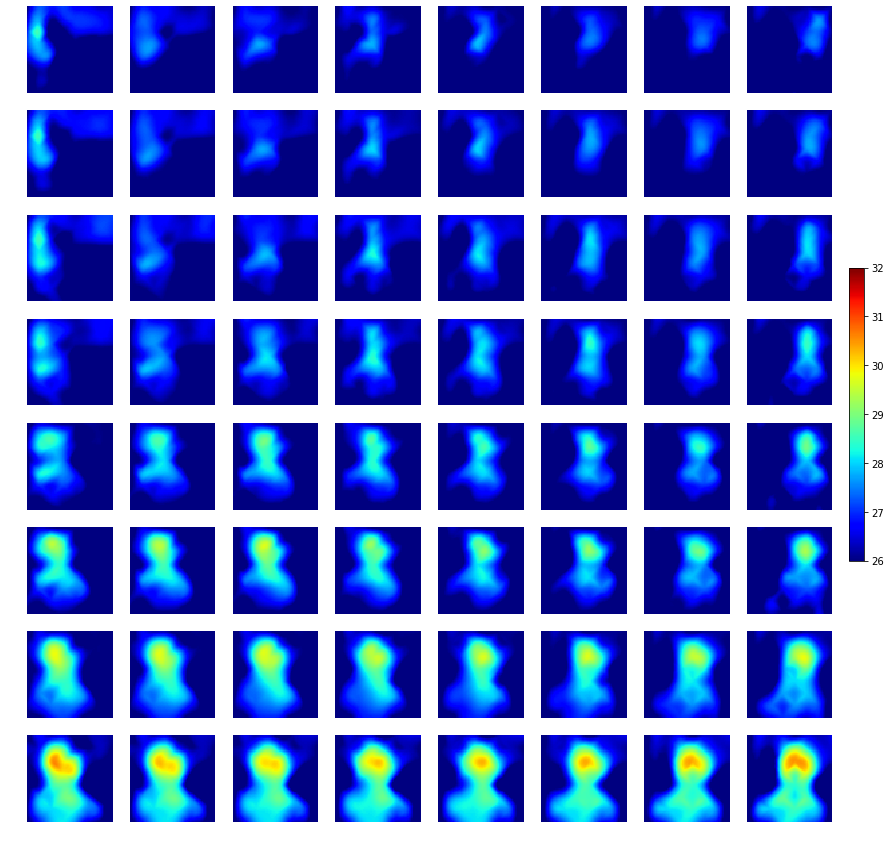

[[28.56 27.68 27.76 27.8  27.89 27.51 27.47 27.68]
 [28.54 27.67 27.74 28.04 28.   27.77 27.63 27.76]
 [28.55 27.81 27.87 28.33 28.19 28.12 27.81 28.12]
 [28.45 27.92 28.14 28.41 28.22 28.46 28.07 28.49]
 [28.62 28.67 28.98 28.74 28.6  28.82 28.52 28.91]
 [29.47 29.45 29.73 29.22 29.12 29.2  28.97 29.33]
 [29.84 29.75 29.74 29.56 29.69 29.71 29.53 29.82]
 [30.62 30.28 30.12 30.24 30.33 30.38 30.43 30.53]]


In [12]:
super_interpol, amax = batch_interpolate(interpol)

show_gtemp(super_interpol[0],8)
# super_interpol[0]

In [13]:
37 - np.mean(amax, axis = 0).round(2) #side vs distance

array([[ 9.24,  9.69,  9.94,  9.81,  9.72, 10.04, 10.03,  9.88],
       [ 8.93,  9.42,  9.63,  9.56,  9.5 ,  9.68,  9.82,  9.8 ],
       [ 8.52,  9.03,  9.2 ,  9.23,  9.2 ,  9.22,  9.51,  9.31],
       [ 8.44,  8.89,  8.94,  8.94,  8.92,  8.88,  9.2 ,  8.86],
       [ 8.35,  8.66,  8.52,  8.52,  8.49,  8.5 ,  8.79,  8.41],
       [ 7.81,  8.15,  7.87,  7.98,  7.95,  7.97,  8.29,  7.84],
       [ 7.54,  7.69,  7.55,  7.53,  7.42,  7.48,  7.73,  7.39],
       [ 6.73,  6.93,  6.97,  6.81,  6.74,  6.78,  6.74,  6.6 ]])

In [14]:
37 - np.mean(amax, axis = 1).round(2) #height vs side

array([[7.92, 8.34, 8.24, 8.21, 8.24, 8.25, 8.45, 8.17],
       [8.2 , 8.48, 8.59, 8.44, 8.47, 8.62, 8.74, 8.51],
       [8.01, 8.26, 8.36, 8.37, 8.34, 8.54, 8.69, 8.43],
       [7.91, 8.28, 8.31, 8.46, 8.31, 8.5 , 8.76, 8.49],
       [8.12, 8.64, 8.74, 8.57, 8.54, 8.65, 8.87, 8.71],
       [8.43, 8.91, 8.93, 8.87, 8.79, 8.82, 8.89, 8.69],
       [8.59, 8.86, 8.82, 8.86, 8.73, 8.71, 8.93, 8.64],
       [8.35, 8.69, 8.62, 8.61, 8.52, 8.45, 8.79, 8.45]])

In [15]:
37 - np.mean(amax, axis = 2).round(2) #distance vs height

array([[ 9.21,  9.11,  8.9 ,  8.73,  8.27,  7.69,  7.3 ,  6.63],
       [ 9.58,  9.43,  9.12,  8.87,  8.57,  8.09,  7.55,  6.83],
       [ 9.82,  9.55,  9.11,  8.82,  8.2 ,  7.47,  7.24,  6.78],
       [ 9.89,  9.45,  8.86,  8.6 ,  8.44,  7.93,  7.32,  6.53],
       [ 9.94,  9.65,  9.21,  8.86,  8.56,  8.16,  7.7 ,  6.76],
       [10.1 ,  9.77,  9.36,  9.09,  8.78,  8.23,  7.81,  7.19],
       [10.04,  9.75,  9.42,  9.13,  8.77,  8.27,  7.8 ,  6.97],
       [ 9.78,  9.62,  9.25,  8.96,  8.63,  8.03,  7.59,  6.62]])

In [16]:
37 - np.mean(amax, axis = (0,2)).round(2) #distance

array([9.79, 9.54, 9.15, 8.88, 8.53, 7.98, 7.54, 6.79])

In [57]:
full_interpol, amax = full_interpolate(16)
full_interpol = full_interpol.reshape(16,16,16,16,8,8).transpose(2,3,0,1,4,5).reshape(16,16,256,8,8)

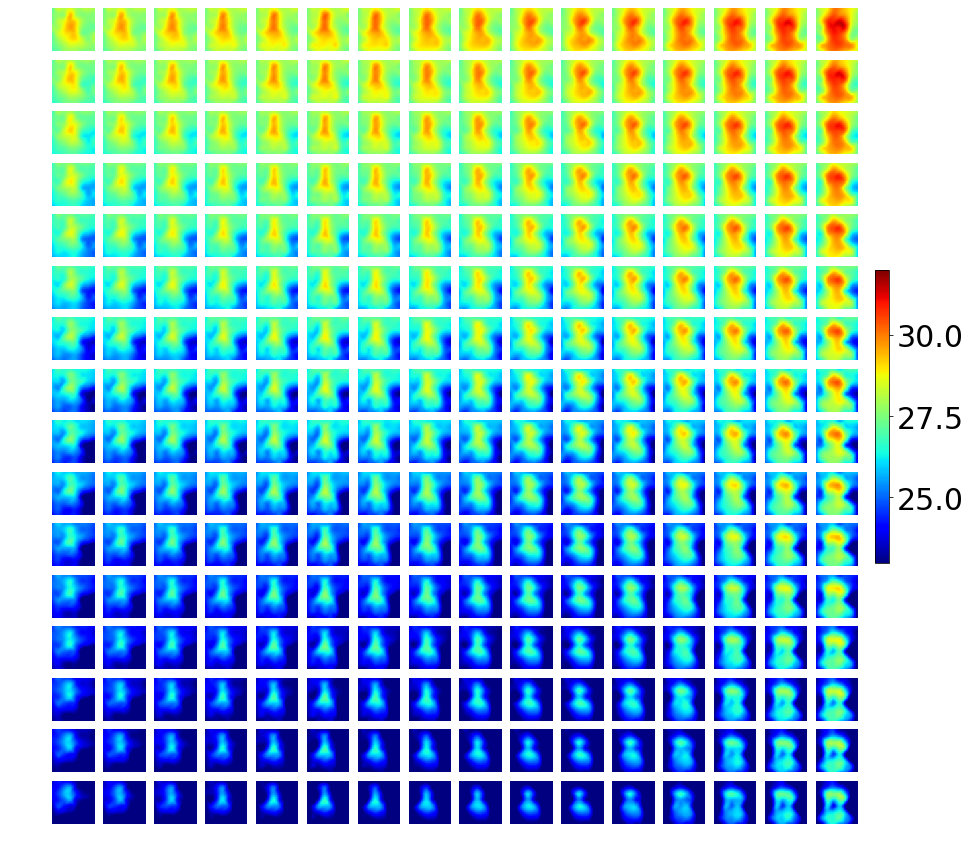

[[29.71 29.8  29.9  30.   30.17 30.34 30.29 30.24 30.3  30.45 30.66 30.79
  30.92 31.08 31.24 31.55]
 [29.45 29.55 29.66 29.77 29.88 30.01 30.   29.99 30.05 30.2  30.41 30.56
  30.72 30.89 31.08 31.29]
 [29.2  29.31 29.41 29.53 29.65 29.76 29.74 29.74 29.81 29.96 30.17 30.34
  30.52 30.71 30.91 31.12]
 [28.94 29.06 29.17 29.3  29.42 29.55 29.51 29.5  29.57 29.72 29.93 30.12
  30.32 30.53 30.75 30.97]
 [28.68 28.81 28.94 29.07 29.2  29.34 29.3  29.27 29.33 29.48 29.68 29.9
  30.12 30.35 30.59 30.83]
 [28.43 28.56 28.7  28.84 28.99 29.13 29.08 29.04 29.11 29.25 29.44 29.68
  29.93 30.18 30.44 30.7 ]
 [28.17 28.31 28.46 28.61 28.77 28.92 28.87 28.81 28.9  29.07 29.25 29.46
  29.73 30.01 30.29 30.57]
 [27.92 28.07 28.22 28.38 28.55 28.71 28.66 28.6  28.68 28.9  29.12 29.24
  29.53 29.84 30.14 30.45]
 [27.65 27.8  27.96 28.13 28.3  28.48 28.41 28.34 28.32 28.53 28.74 28.91
  29.22 29.55 29.88 30.21]
 [27.36 27.51 27.67 27.85 28.04 28.22 28.12 28.02 27.92 28.01 28.17 28.47
  28.8  29.15 29.5

In [58]:
show_gtemp(full_interpol[0,7],16, mintemp = 23, maxtemp = 32)

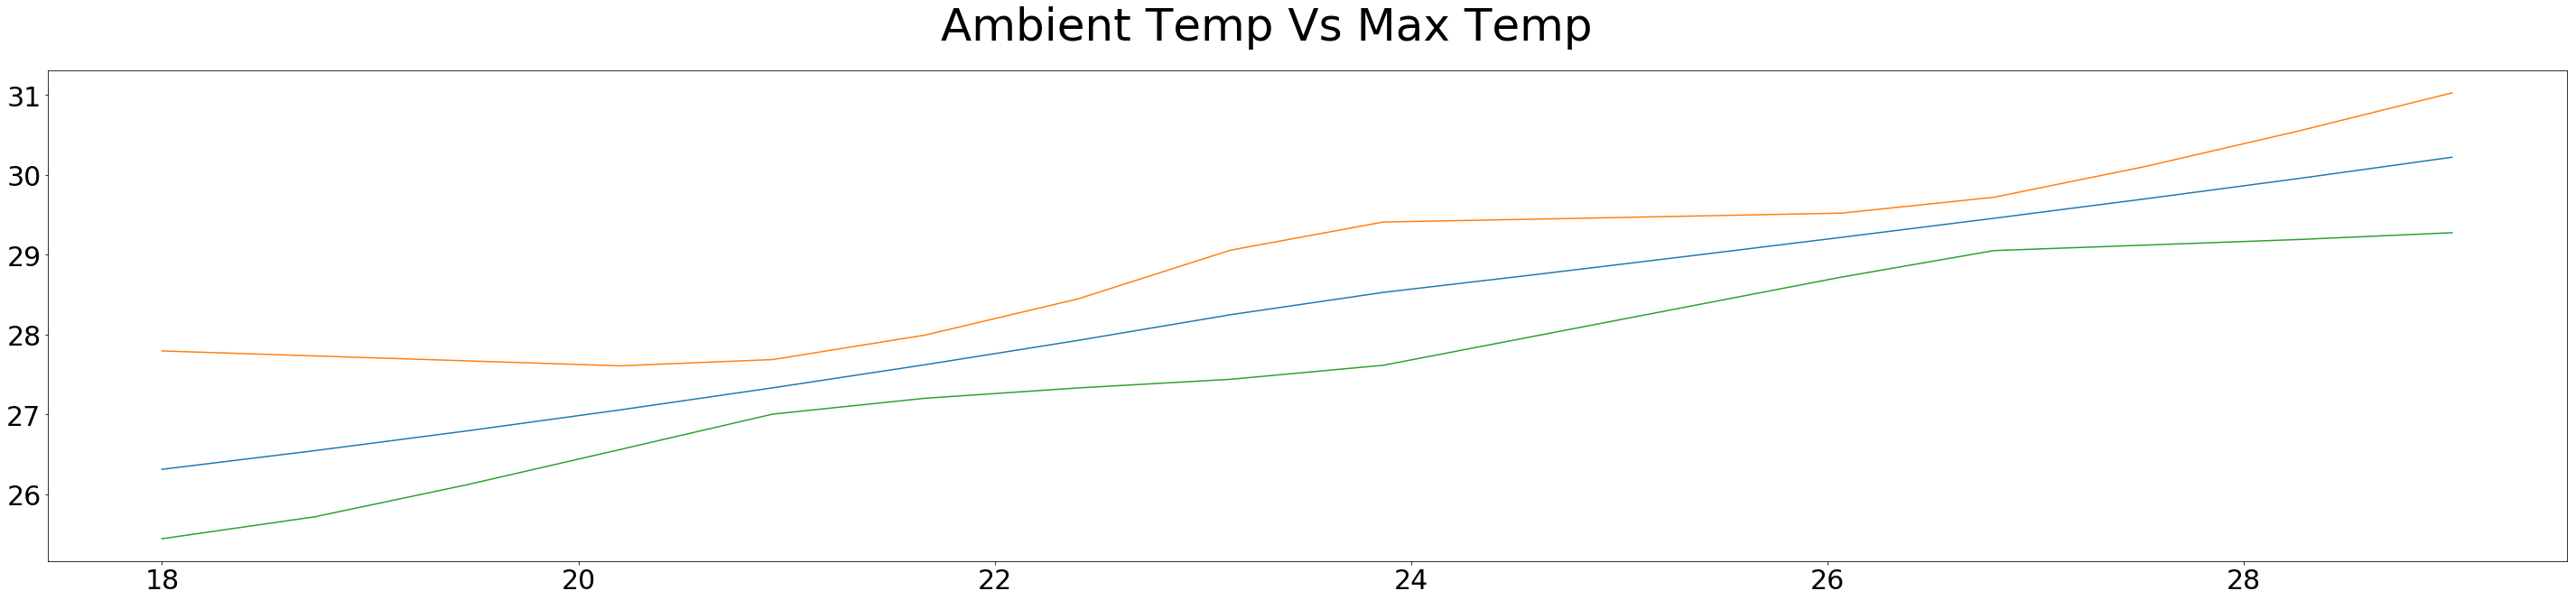

In [59]:
mean = np.mean(amax)
plt.figure(figsize=(50, 10))
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
center = amax-np.mean(amax, axis = 0)
plt.plot(np.linspace(29,18,16),np.mean(center, axis = (1,2,3))+mean) 
plt.plot(np.linspace(29,18,16),np.amax(center, axis = (1,2,3))+mean)
plt.plot(np.linspace(29,18,16),np.amin(center, axis = (1,2,3))+mean)
plt.suptitle('Ambient Temp Vs Max Temp', fontsize = 50)
plt.show()

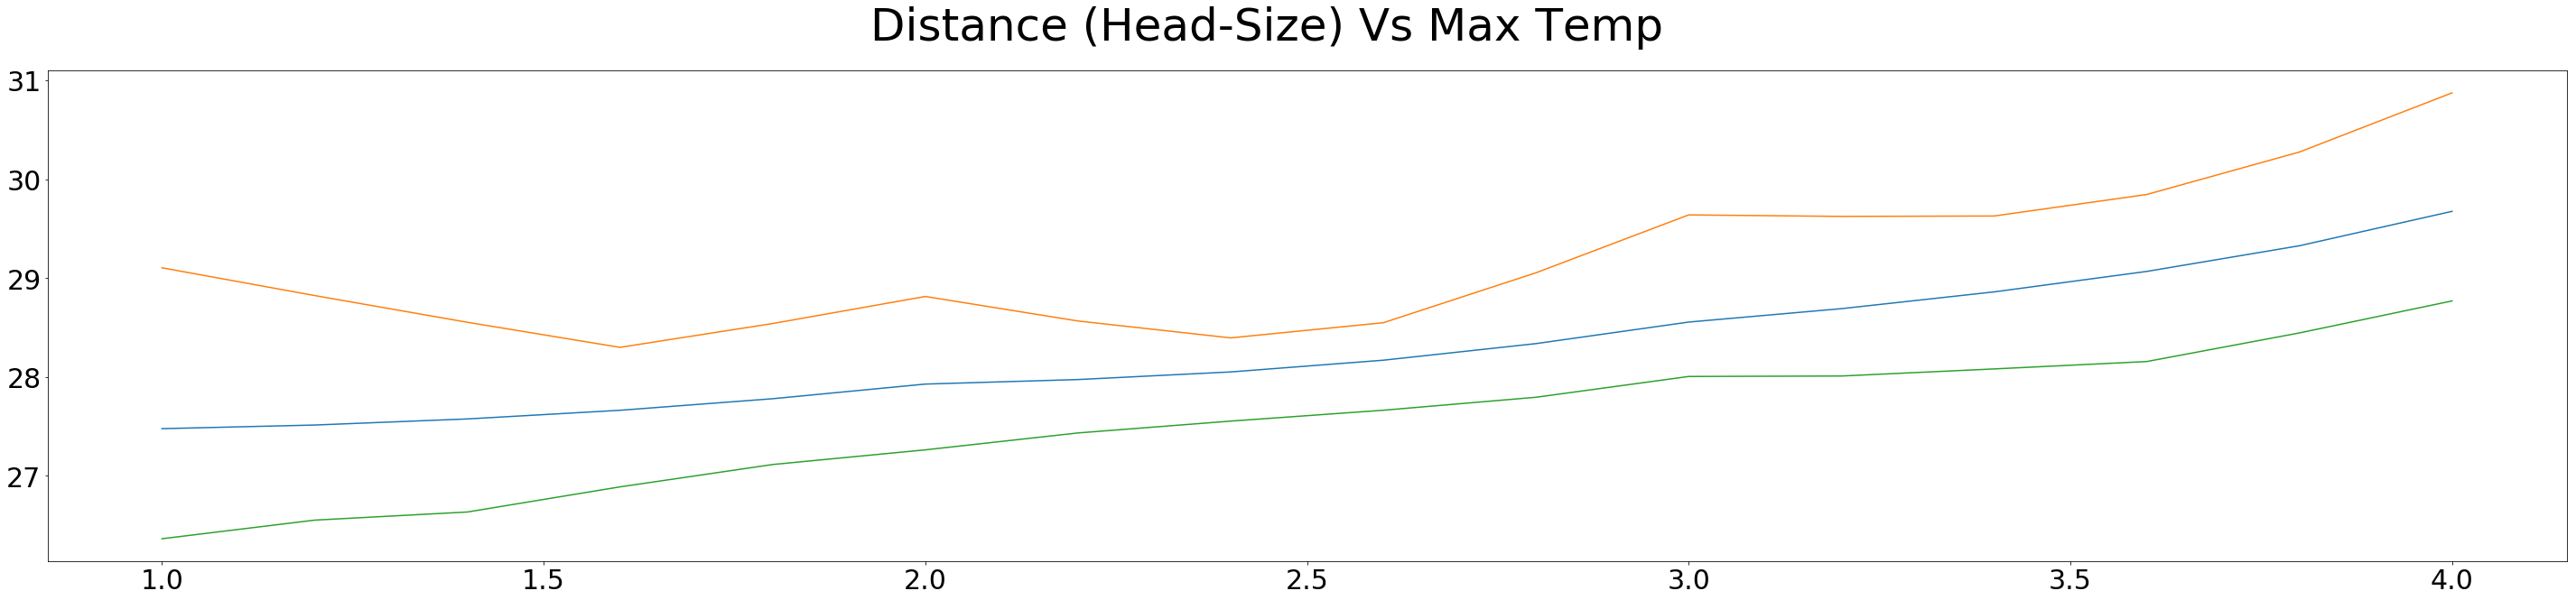

In [60]:
plt.figure(figsize=(50, 10))
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
center = amax.transpose(1,0,2,3)-np.mean(amax, axis = 1)
plt.plot(np.linspace(1,4,16),np.mean(center, axis = (1,2,3)) + mean)
plt.plot(np.linspace(1,4,16),np.amax(center, axis = (1,2,3)) + mean)
plt.plot(np.linspace(1,4,16),np.amin(center, axis = (1,2,3)) + mean)
plt.suptitle('Distance (Head-Size) Vs Max Temp', fontsize = 50)
plt.show()

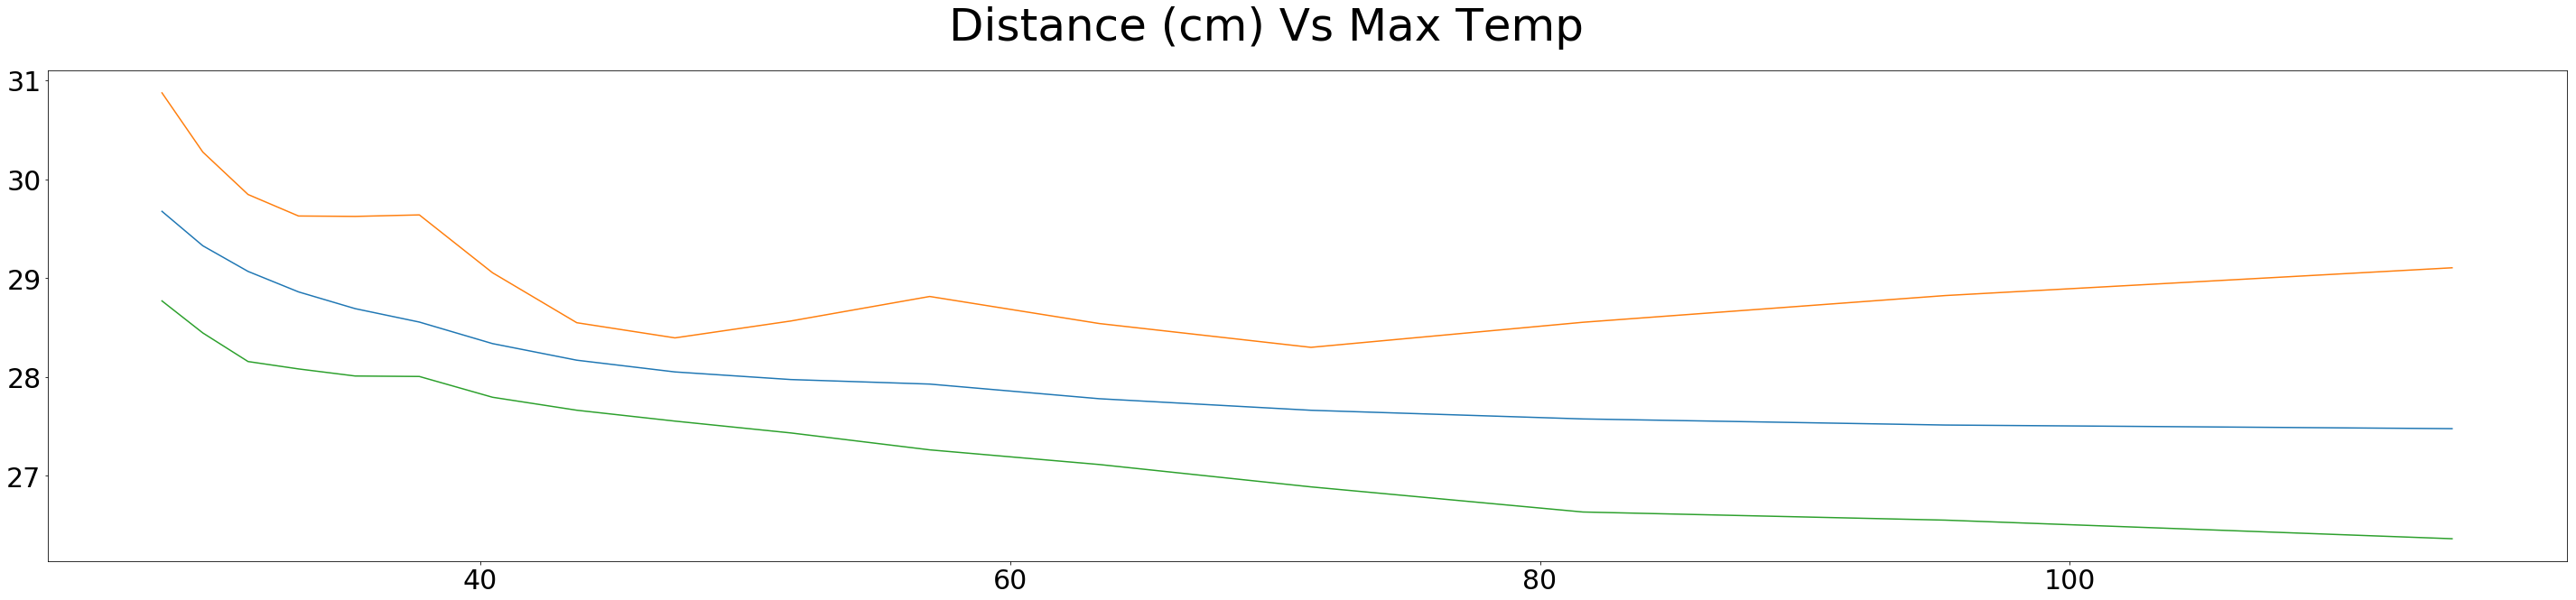

In [61]:
hs_dis = np.linspace(1,4,16)
dis = 7.5/np.tan(np.deg2rad(3.75*hs_dis))
    
plt.figure(figsize=(50, 10))
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
plt.plot(dis,np.mean(center, axis = (1,2,3)) + mean)
plt.plot(dis,np.amax(center, axis = (1,2,3)) + mean)
plt.plot(dis,np.amin(center, axis = (1,2,3)) + mean)
plt.suptitle('Distance (cm) Vs Max Temp', fontsize = 50)
plt.show()

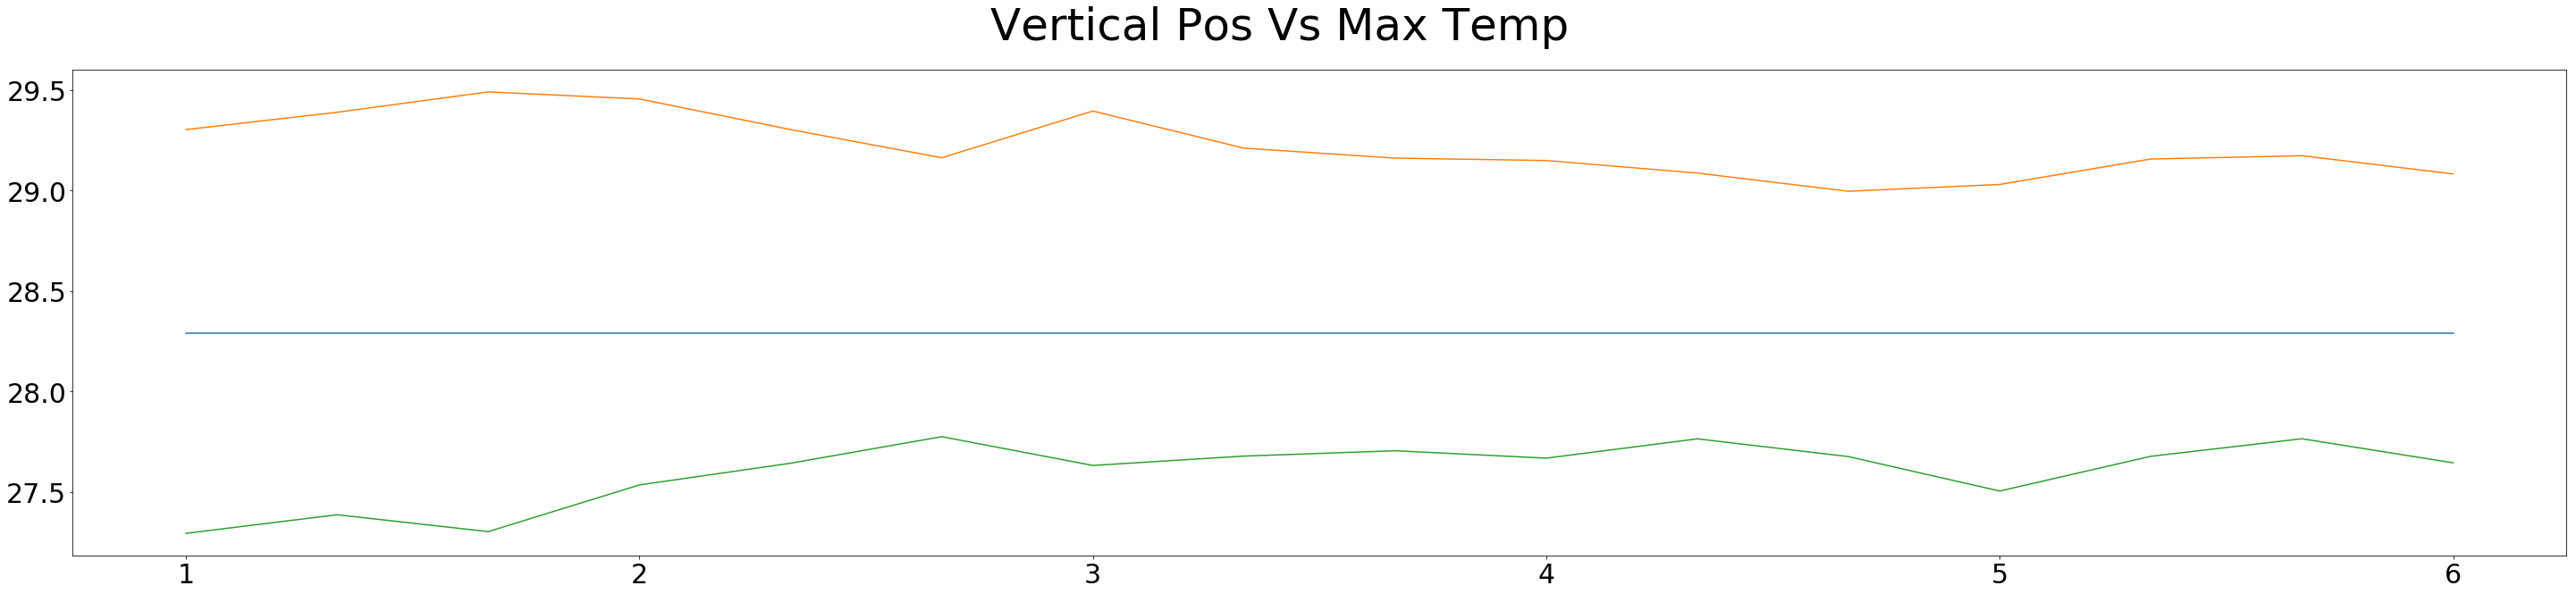

In [62]:
plt.figure(figsize=(50, 10))
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30)
center = amax.transpose(2,0,1,3)-np.mean(amax, axis = 2)
plt.plot(np.linspace(1,6,16),np.mean(center, axis = (0,1,2)) + mean)
plt.plot(np.linspace(1,6,16),np.amax(center, axis = (0,1,2)) + mean)
plt.plot(np.linspace(1,6,16),np.amin(center, axis = (0,1,2)) + mean)
plt.suptitle('Vertical Pos Vs Max Temp', fontsize = 50)
plt.show()

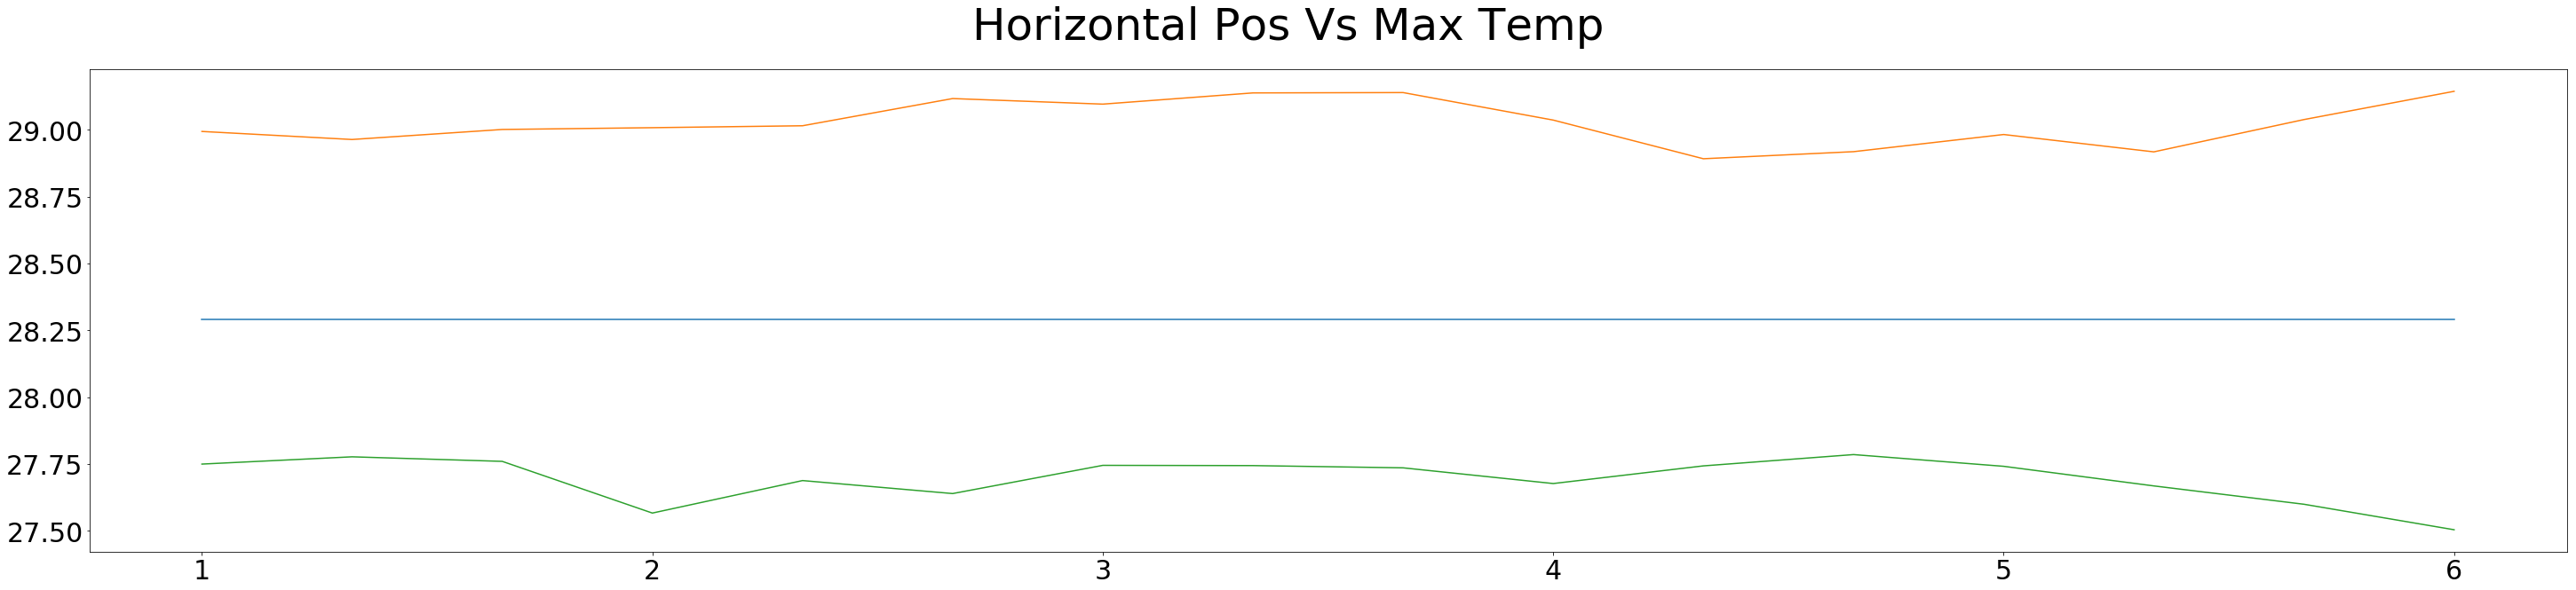

In [63]:
plt.figure(figsize=(50, 10))
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
center = amax.transpose(3,0,1,2)-np.mean(amax, axis = 3)
plt.plot(np.linspace(1,6,16),np.mean(center, axis = (0,1,2)) + mean)
plt.plot(np.linspace(1,6,16),np.amax(center, axis = (0,1,2)) + mean)
plt.plot(np.linspace(1,6,16),np.amin(center, axis = (0,1,2)) + mean)
plt.suptitle('Horizontal Pos Vs Max Temp', fontsize = 50)
plt.show()

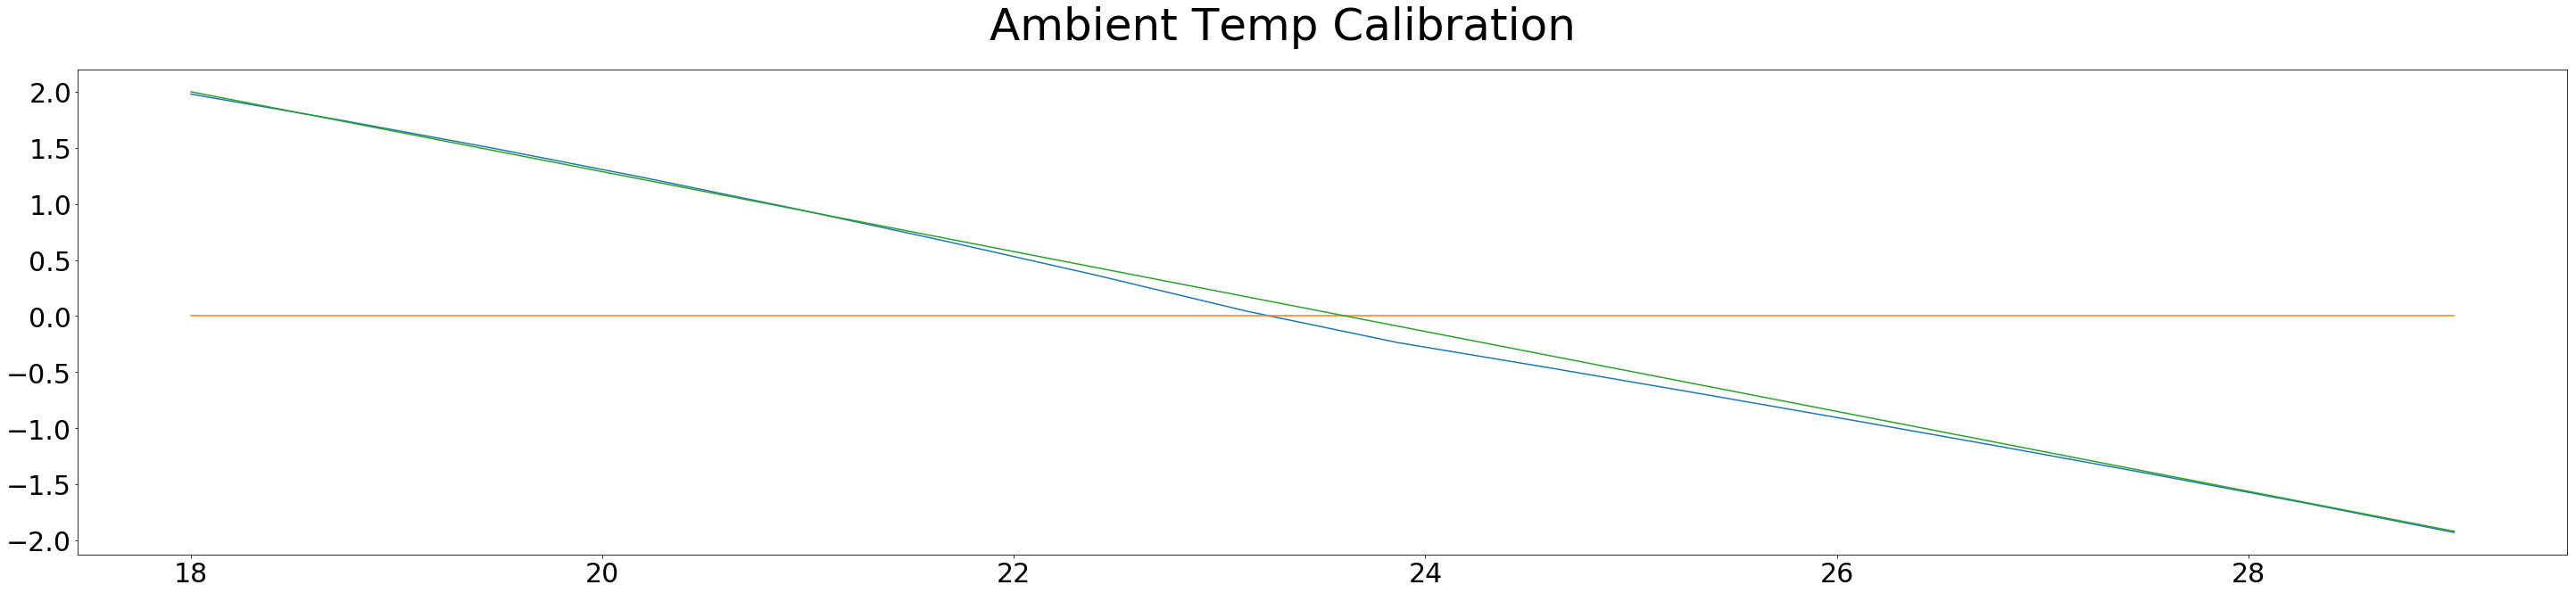

In [79]:
plt.figure(figsize=(50, 10))
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
center = amax-np.mean(amax, axis = 0)
plt.plot(np.linspace(29,18,16),-np.mean(center, axis = (1,2,3))) 
plt.plot(np.linspace(18,29,16),np.zeros(16))
plt.plot(np.linspace(18,29,16),np.linspace(2,-1.92,16))
plt.suptitle('Ambient Temp Calibration', fontsize = 50)
plt.show()

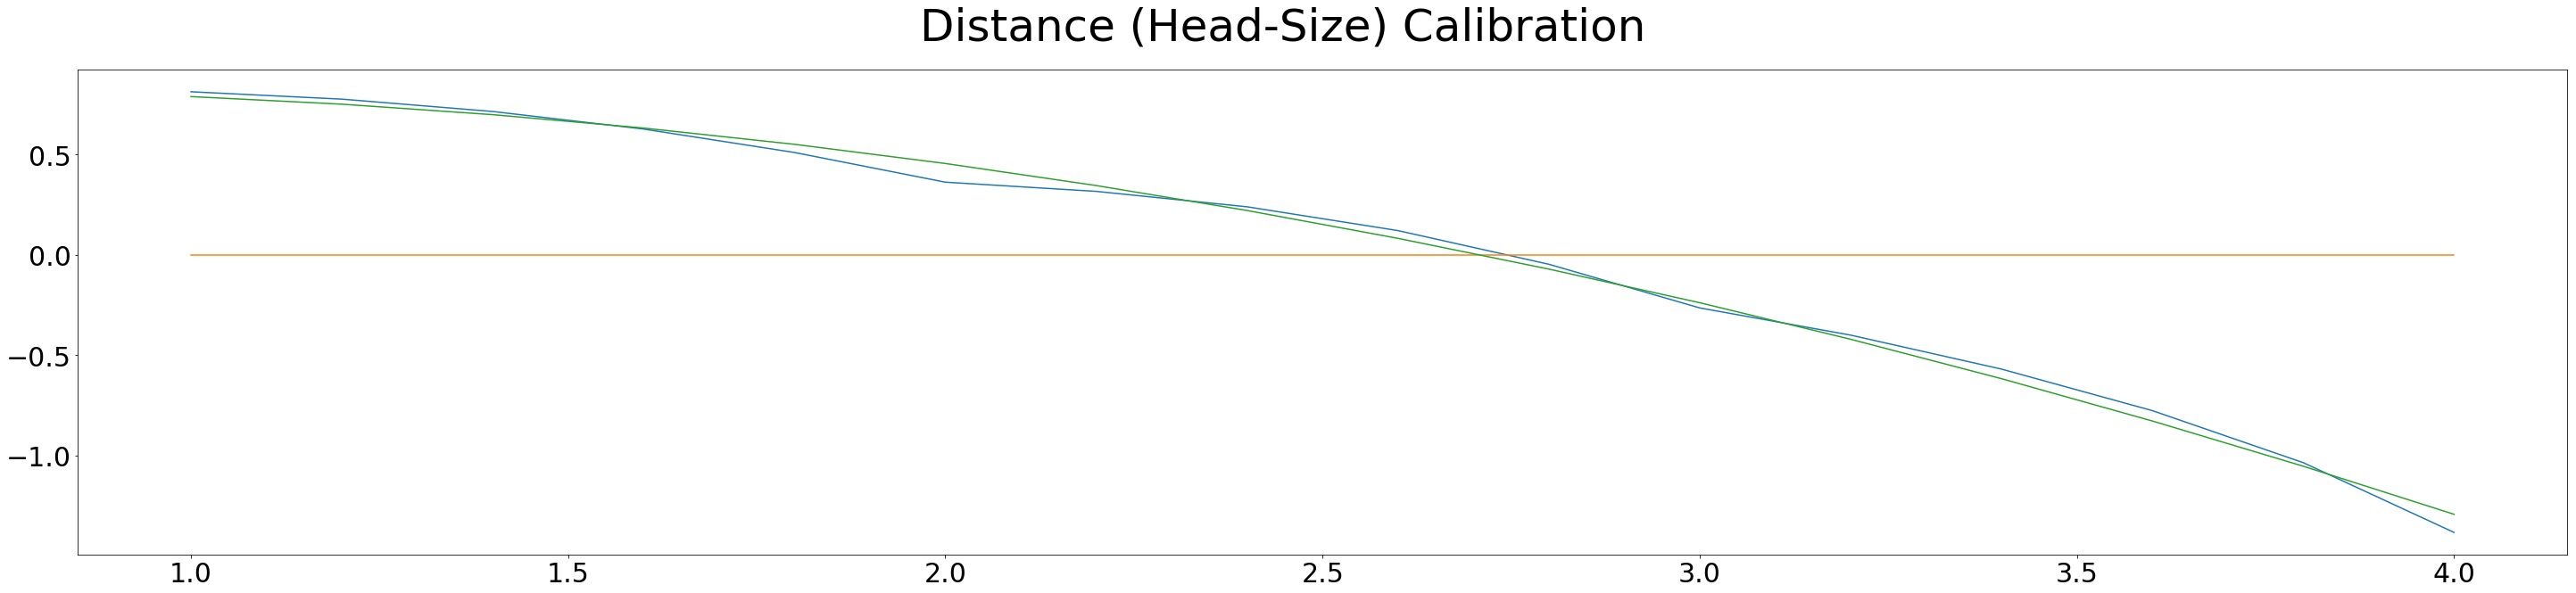

In [84]:
plt.figure(figsize=(50, 10))
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
center = amax.transpose(1,0,2,3)-np.mean(amax, axis = 1)
linsp = np.linspace(1,4,16)

poly = np.polyfit(linsp,-np.mean(center, axis = (1,2,3)),2)
plt.plot(linsp,-np.mean(center, axis = (1,2,3)))
plt.plot(linsp,np.zeros(16))
plt.plot(linsp,poly[0]*(linsp**2) + poly[1]*linsp + poly[2])
plt.suptitle('Distance (Head-Size) Calibration', fontsize = 50)
plt.show()

array([-0.18036412,  0.20751259,  0.7618038 ])

In [70]:
diff = 36.5-np.mean(amax)
diff

8.209654380907974

In [89]:
amax[13,7,6,6]

26.483545624218973

In [90]:
np.linspace(29,18,16)[13]

19.46666666666667

In [91]:
np.linspace(1,4,16)[7]

2.4000000000000004

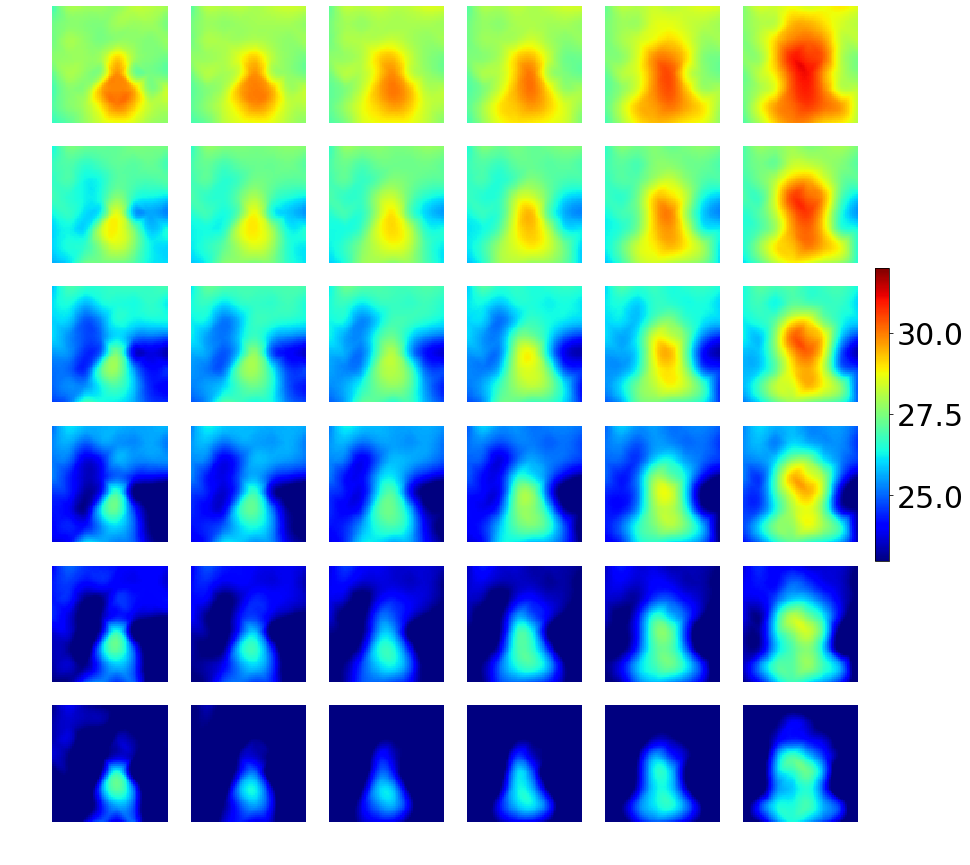

[[30.17 30.03 30.07 30.13 30.51 31.16]
 [28.91 28.97 29.12 29.49 30.02 30.81]
 [27.9  27.98 28.24 28.89 29.53 30.47]
 [27.35 27.24 27.36 28.04 28.73 29.71]
 [27.3  26.81 26.78 27.15 27.65 28.55]
 [27.27 26.4  26.22 26.53 26.69 27.39]]


In [76]:
tiny_interpol, tiny_amax = full_interpolate(6)
tiny_interpol = tiny_interpol.reshape(6,6,6,6,8,8).transpose(2,3,0,1,4,5).reshape(6,6,36,8,8)
show_gtemp(tiny_interpol[3,3],6, mintemp = 23, maxtemp = 32)

In [87]:
def get_bodytemp(temp,ambient,distance):
    amb_cal = -3.92/11 * (ambient-29)-1.92
    dis_cal = -0.18036412*distance**2 +0.20751259*distance + 0.7618038
    cal = 8.209654380907974
    return temp + amb_cal + dis_cal + cal

In [88]:
get_bodytemp(30.85,27.5,3.8)

36.62009358465343

In [94]:
get_bodytemp(26.5,19.5,2.4)

36.39604561116252